# Genetic Algorithm

A basic genetic algorithm used to optimize hyperparameters. The algorithm will try to optimise based on the loss function that is used. It does this by 3 genetic operations:  full mutation, partial mutation and crossover.

Gene, Genome and Population classes are here as data classes: they only contain data. MetaGene, MetaGenome and MetaPopulation contain metadata (such as gene names, genome fitness function, ...) not directly useful to the data classes themselves.

The code is kept very simple and comprehensive deliberately, so you can experiment on it and tweak it to add features or improve the results.
You can find herebelow 2 examples, which are detailed later.

In [1]:
import random
import math
from scipy.stats import qmc
from tqdm.notebook import trange
import copy
import numpy as np
import matplotlib.pyplot as plt

random.seed(20)

class Gene:
    ''' Value the genetic algorithm tries to optimize '''
    def __init__(self, metagene, value):
        '''
        : param metagene:    gene representation
        : param value:       gene value
        '''
        self.metagene = metagene
        self.value = value

    def __repr__(self):
        '''
        : return repr: string representation of this genome
        '''
        return f'{self.metagene.name}: {self.value:.5f}'



class MetaGene:
    ''' Gene representation '''
    def __init__(self, name, bounds, dtype = np.float32):
        '''
        : param name:      gene name
        : param bounds:    tuple containing the lower and upper limits of the
        :                  gene's possible values
        '''
        self.name = name
        self.bounds = bounds
        self.dtype = dtype

    def make_gene(self, value=None):
        '''
        : param value:    value to give to the gene. If not set, a random value is used

        : return gene:    gene with a random value between this metagene's bounds
        '''
        if value is None:
            value = random.uniform(self.bounds[0], self.bounds[1])
        tvalue = np.array([value]).astype(self.dtype)[0]
        return Gene(self, tvalue)



class Genome:
    ''' Set of genes '''
    def __init__(self, metagenome, genes):
        '''
        : param metagenome:    genome representation
        : param genes:         list of the genomes' genes
        '''
        self.metagenome = metagenome
        self.genes = genes
        self.fitness = metagenome.fitness_fn([ g.value for g in genes ])

    def __repr__(self):
        '''
        : return repr: string representation of this genome
        '''
        return f'({repr(self.genes)}, fitness: {self.fitness:.5f})'



class MetaGenome:
    ''' Genome representation '''
    def __init__(self, metagenes, fitness_fn):
        '''
        : param metagenes:     list of metagenes that constitute the metagenome
        : param fitness_fn:    function used to calculate a genome's fitness
        '''
        self.metagenes = metagenes
        self.fitness_fn = fitness_fn

    def make_genome(self, values=None):
        '''
        : param value:      values to give to the genome's genes. If not set, random values are used 

        : return genome:    genome with random genes created from this metagenome
        '''
        if values is None:
            return Genome(self, [ metagene.make_gene() for metagene in self.metagenes ])
        else:
            assert len(values) == len(self.metagenes), f'Expected {len(self.metagenes)} values, got {len(values)}'
            return Genome(self, [ metagene.make_gene(values[i]) for i, metagene in enumerate(self.metagenes) ])



class Population:
    ''' Set of genomes '''
    def __init__(self, metapopulation, genomes, generation_id=None):
        '''
        : param metapopulation:    population representation
        : param genomes:           list of genomes that constitute the population
        : param generation_id:     index of the generation
        '''
        self.metapopulation = metapopulation
        self.genomes = genomes
        self.generation_id = generation_id

    def __repr__(self):
        '''
        : return repr: string representation of this population
        '''
        return repr(self.genomes)



class MetaPopulation:
    ''' Population representation '''
    def __init__(self, metagenome, n_genomes):
        '''
        : param metagenome:    population's genomes representation
        : param n_genomes:     population size
        '''
        self.metagenome = metagenome
        self.n_genomes = n_genomes

    def make_population(self, use_low_discrepancy=False, **kwargs):
        '''
        : return population:    population created from this metapopulation
        '''
        if use_low_discrepancy:
            # generate population equally distributed in the space
            sampler = qmc.Halton(d=len(self.metagenome.metagenes), scramble=False)
            samples = sampler.random(n=self.n_genomes)
            l_bounds = [ metagene.bounds[0] for metagene in self.metagenome.metagenes ]
            u_bounds = [ metagene.bounds[1] for metagene in self.metagenome.metagenes ]
            samples = qmc.scale(samples, l_bounds, u_bounds)
            return Population(self, [ metagenome.make_genome(sample) for sample in samples ], **kwargs)
        else:
            return Population(self, [ metagenome.make_genome() for _ in range(self.n_genomes) ], **kwargs)



class GeneticOperations:
    ''' Genetic operations wrapper '''
    @staticmethod
    def full_mutation(metagenome, pick_n_parents):
        '''
        Creates a fully random new genome

        : param metagenome:        metagenome used
        : param pick_n_parents:    function used to pick n parents for the
        :                          genetic operation to use

        : return genome:    new genome
        '''
        return metagenome.make_genome()

    @staticmethod
    def partial_mutation(metagenome, pick_n_parents):
        '''
        Copies a genome from the population and changes randomly one of his genes

        : param metagenome:        metagenome used
        : param pick_n_parents:    function used to pick n parents for the
        :                          genetic operation to use

        : return genome:    new genome
        '''
        parent = pick_n_parents(1)[0]
        genes = parent.genes[:]
        mutation_pos = random.randrange(0, len(metagenome.metagenes))
        metagene = metagenome.metagenes[mutation_pos]
        genes[mutation_pos] = metagene.make_gene()
        return Genome(metagenome, genes)

    @staticmethod
    def crossover(metagenome, pick_n_parents):
        '''
        Performs a uniform crossover between 2 parents: pick randomly genes
        from parent 1 and 2
        
        : param metagenome:        metagenome used
        : param pick_n_parents:    function used to pick n parents for the
        :                          genetic operation to use

        : return genome:    new genome
        '''
        p1, p2 = pick_n_parents(2)
        genes = []
        for i in range(len(p1.genes)):
            if random.randrange(0, 2) == 0:
                genes.append(p1.genes[i])
            else:
                genes.append(p2.genes[i])
        return Genome(metagenome, genes)



class GeneticAlgorithm:
    ''' Genetic algorithm logic wrapper class '''
    def __init__(
        self,
        metapopulation,
        n_generations,
        culling_ratio,
        genetic_operations,
        best_is = 'maximum',
        use_low_discrepancy = False,
        verbose = False
    ):
        '''
        : param metapopulation:         genetic algorithm's population representation
        : param n_generations:          number of generations to run
        : param culling_ratio:          part of the population to discard when culling it
        : param genetic_operations:     list of tuples containing a genetic operation and
        :                               its weight to use when populating
        : param best_is:                indicates which fitness value is best, either 'maximum' or 'minimum'
        : param use_low_discrepancy:    use a low discrepancy sequence to initialize first generation evenly
        : param verbose:                verbosity of the genetic algorithm (if True, will log progress)
        '''
        self.metapopulation = metapopulation
        self.n_generations = n_generations
        self.culling_ratio = culling_ratio
        self.genetic_operations = genetic_operations
        self.best_is = best_is
        self.use_low_discrepancy = use_low_discrepancy
        self.verbose = verbose

    def run(self):
        '''
        Run the genetic algorthm
        
        : return populations:    array containing the population of each generation
        '''
        self.log(f'Running genetic algorithm over {self.n_generations} generations, best is: {self.best_is}')

        populations = []
        populations.append(self.metapopulation.make_population(self.use_low_discrepancy, generation_id=0))

        with trange(self.n_generations) as tr:
            for i in tr:
                # create new generation
                populations.append(copy.deepcopy(populations[-1]))
                px = populations[-1] # current generation
                px.generation_id = i + 1

                # sort current population's genomes by fitness
                px.genomes = sorted(px.genomes, key = lambda genome: genome.fitness, reverse = self.best_is == 'maximum')

                padding = int(math.log(self.n_generations) / math.log(10)) + 1
                self.log(f'{i + 1:>{padding}}, best genome: {px.genomes[0]}')

                tr.set_postfix(fitness=f'{px.genomes[0].fitness:.5f}')

                if i == self.n_generations - 1:
                    # this is the last population to evaluate, we can skip 
                    # the culling and populating parts
                    continue

                # cull the current population (discard less-fit genomes)
                px.genomes = px.genomes[:math.ceil(len(px.genomes) * (1 - self.culling_ratio))]

                # populate the current, culled population using genetic operations
                n_to_populate = self.metapopulation.n_genomes - len(px.genomes)
                pick_n_parents = lambda n: self.pick_parents_from_population(px, n)
                metagenome = self.metapopulation.metagenome
                for i in range(n_to_populate):
                    operation = self.pick_genetic_operation()
                    px.genomes.append(operation(metagenome, pick_n_parents))
        return populations

    def log(self, *values):
        '''
        Log values if the genetic algorithm's verbosity is set to True

        : param values: values to log
        '''
        if self.verbose:
            print(*values)

    def pick_parents_from_population(self, population, n_parents):
        '''
        : param population:    population to select parents from
        : param n_parents:     number of parents to select from the population
        
        : return parents:      list of n_parents parents selected from the population
        '''
        return random.sample(population.genomes, n_parents)

    def pick_genetic_operation(self):
        '''
        Randomly pick a genetic operation, based on their weight
        
        : return fn:    the seleced genetic operation's function
        '''
        weights_sum = sum([ weight for fn, weight in self.genetic_operations ])
        rand = random.uniform(0, weights_sum)
        acc = 0.
        for fn, weight in self.genetic_operations:
            acc += weight
            if acc >= rand:
                return fn

    def plot_2d(self, population, true_x = None, true_y = None):
        '''
        Plot a population of genomes
        Only works for genomes with 1 or 2 genes
        
        : param population:    population to plot
        '''
        genomes = population.genomes
        metagenes = population.metapopulation.metagenome.metagenes
        assert len(metagenes) <= 2, 'Cannot plot a population of genomes with other than 2 genes'
        fig = plt.figure()
        ax = fig.add_subplot()
        if population.generation_id is not None:
            ax.set_title(f'Generation {population.generation_id}')
        x = [ genome.genes[0].value for genome in genomes ]
        y = None
        c = [ genome.fitness for genome in genomes ]
        if len(metagenes) == 1:
            plt.xlabel(metagenes[0].name)
            plt.ylabel('fitness')
            y = [ genome.fitness for genome in genomes ]
        elif len(metagenes) == 2:
            bounds = [ mg.bounds for mg in population.metapopulation.metagenome.metagenes ]
            ax.set_xlim(bounds[0])
            ax.set_ylim(bounds[1])
            plt.xlabel(metagenes[0].name)
            plt.ylabel(metagenes[1].name)
            y = [ genome.genes[1].value for genome in genomes ]
        ax.scatter(x, y, s=50, c=c, cmap="coolwarm")
        if true_x and true_y:
            ax.plot(true_x, true_y, alpha=0.3)


## First example: basic genetic algorithm

Simple genetic algorithm for demo purposes. Each genome has 2 genes x and y, plotted in a 2d space for visualization. The GA will look for the best-fitting genomes, according to a fitness function, which is the distance to the coordinate (0.5;0.5). The best-fitting genomes are those with the lowest distance. You can play with the GA parameters such as the number of genomes per generation, the number of generations, the initialization method (using low-discrepancy sequence or random initialization), ...

Running genetic algorithm over 5 generations, best is: minimum


  0%|          | 0/5 [00:00<?, ?it/s]

1, best genome: ([x: 0.54688, y: 0.53086], fitness: 0.05612)
2, best genome: ([x: 0.54688, y: 0.53086], fitness: 0.05612)
3, best genome: ([x: 0.54688, y: 0.53086], fitness: 0.05612)
4, best genome: ([x: 0.51025, y: 0.48148], fitness: 0.02117)
5, best genome: ([x: 0.51025, y: 0.48148], fitness: 0.02117)


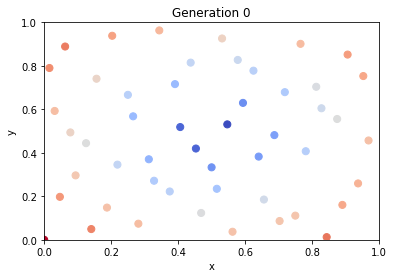

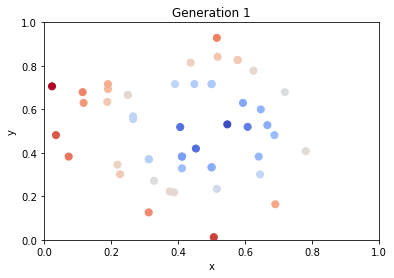

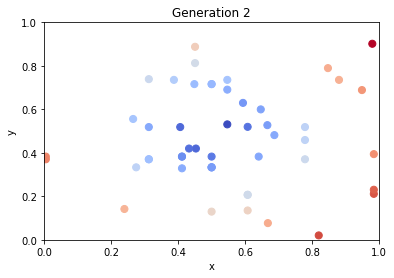

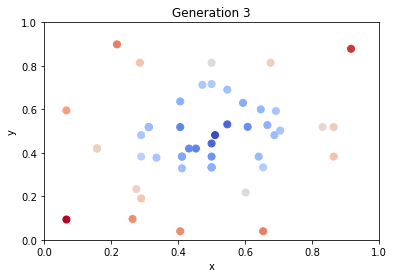

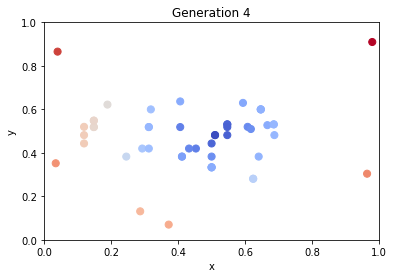

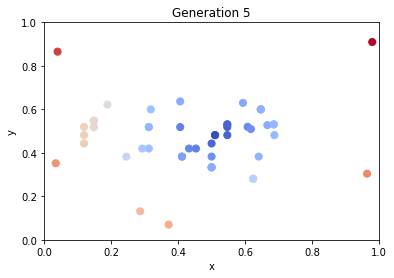

In [2]:
metagenome = MetaGenome(
    metagenes = [ MetaGene('x', (0., 1.)), MetaGene('y', (0., 1.)) ],
    fitness_fn = lambda values: math.sqrt((0.5 - values[0]) ** 2 + (0.5 - values[1]) ** 2)
)

metapopulation = MetaPopulation(
    metagenome = metagenome,
    n_genomes = 50
)

ga = GeneticAlgorithm(
    metapopulation = metapopulation,
    n_generations = 5,
    culling_ratio = 0.6,
    genetic_operations = [
        ( GeneticOperations.full_mutation,    0.3 ),
        ( GeneticOperations.partial_mutation, 0.4 ),
        ( GeneticOperations.crossover,        0.3 )
    ],
    best_is = 'minimum',
    use_low_discrepancy=True,
    verbose = True
)

populations = ga.run()
for p in populations:
    ga.plot_2d(p)


## Second example: KNN hyper-parameters optimization

This second example uses a genetic algorithm in an attempt to optimize hyper-parameters for a ML algorithm. We used KNN on [Kaggle's Iris dataset](https://www.kaggle.com/uciml/iris), as it is very simple and quick to evaluate. The GA will look for the number of neighbors which give the best accuracy score on the validation set.

First, to make it easier to understand, we plot the accuracy score you can expect for every possible number of neighbors. Using all columns from the iris dataset, we would get almost 100% accuracy with any number of neighbors, so it would not be interesting to optimize. Thus, for demo purposes, we only use the first 2 columns (sepal length and width), which give an overall poor accuracy except for a certain numbers of neighbors, the best possible being 19 in this case.

We then run the GA on this dataset with these settings to try and find the best amount of neighbors programmatically.

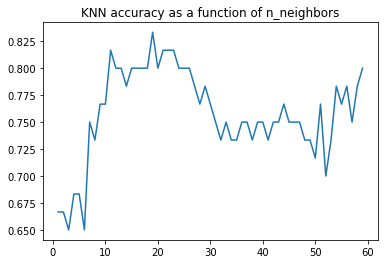

In [3]:
from pipetorch import *
from pipetorch.data.datasets import iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

dataset = iris()
features = dataset[['sepal length (cm)', 'sepal width (cm)']]
targets = dataset[['target']].to_numpy().ravel()
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, random_state=1)

def evaluator(genes):
    n_neighbors = genes[0]
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    y_test_pred = knn.predict(x_test)
    return precision_score(y_test, y_test_pred, average='micro')

plt.subplots()
true_x = range(1, len(y_test))
true_y = [ evaluator([i]) for i in range(1, len(y_test)) ]
plt.title('KNN accuracy as a function of n_neighbors')
_ = plt.plot(true_x, true_y)

Running genetic algorithm over 8 generations, best is: maximum


  0%|          | 0/8 [00:00<?, ?it/s]

1, best genome: ([n_neighbors: 23.00000], fitness: 0.81667)
2, best genome: ([n_neighbors: 23.00000], fitness: 0.81667)
3, best genome: ([n_neighbors: 23.00000], fitness: 0.81667)
4, best genome: ([n_neighbors: 23.00000], fitness: 0.81667)
5, best genome: ([n_neighbors: 23.00000], fitness: 0.81667)
6, best genome: ([n_neighbors: 23.00000], fitness: 0.81667)
7, best genome: ([n_neighbors: 23.00000], fitness: 0.81667)
8, best genome: ([n_neighbors: 19.00000], fitness: 0.83333)


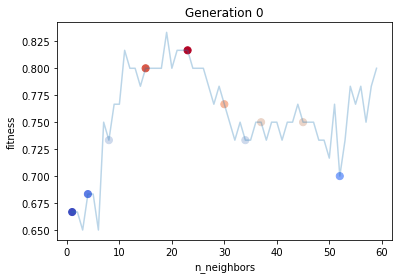

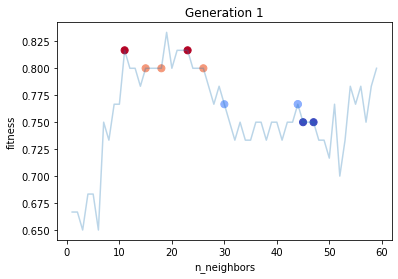

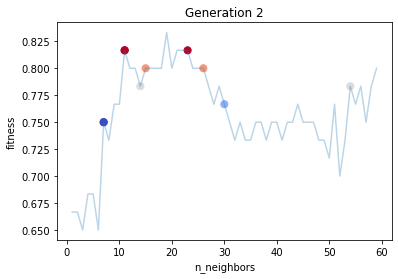

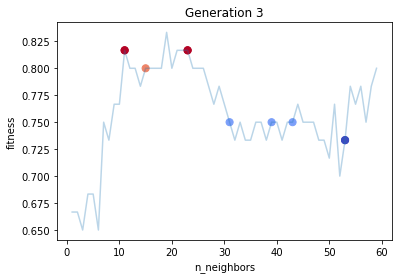

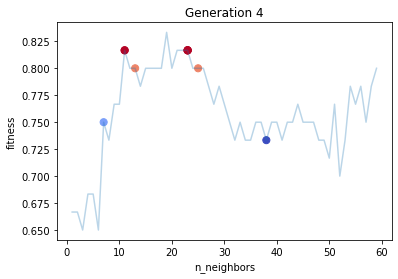

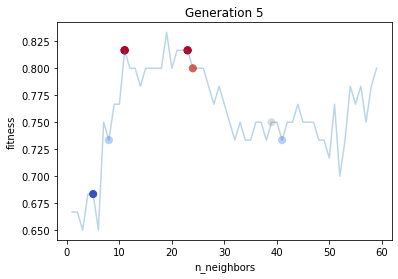

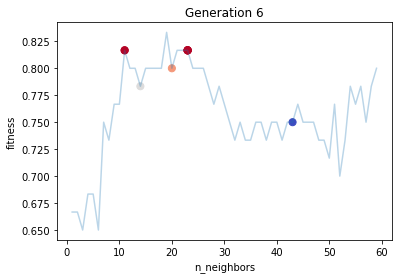

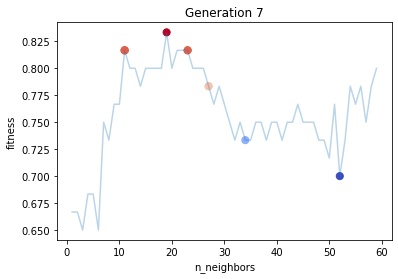

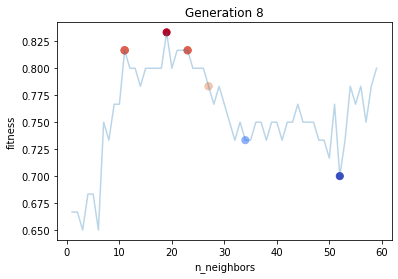

In [4]:
metagenome = MetaGenome(
    metagenes = [ MetaGene('n_neighbors', (1, len(y_test)), dtype=int) ],
    fitness_fn = evaluator
)

metapopulation = MetaPopulation(
    metagenome = metagenome,
    n_genomes = 10
)

ga = GeneticAlgorithm(
    metapopulation = metapopulation,
    n_generations = 8,
    culling_ratio = 0.6,
    genetic_operations = [
        ( GeneticOperations.full_mutation,    0.3 ),
        ( GeneticOperations.partial_mutation, 0.4 ),
        ( GeneticOperations.crossover,        0.3 )
    ],
    best_is = 'maximum',
    use_low_discrepancy=True,
    verbose = True
)

populations = ga.run()

for p in populations:
    ga.plot_2d(p, true_x, true_y)
